# <center> "Sweet" Introduction to iSpec </center>

<font color='gray'> Diego Cuenda Muñoz -- Centro de Astrobiología, CSIC-INTA -- 10/january/2024 </font>

<font color='gray'>dcuenda@cab.inta-csic.es</font>

## 1. What is it?

[iSpec](https://www.blancocuaresma.com/s/iSpec) is an open source framework for spectral analysis developed by [Sergi Blanco-Cuaresma](https://www.blancocuaresma.com/s/#). This tool can be installed on Linux or Mac environments following the steps provided [here](https://www.blancocuaresma.com/s/iSpec/manual/installation).

## 2. The visual interface

iSpec includes a visual interface which is very useful to have a look to your spectra and perform some simple tasks. However, the complete set of functionalities included in iSpec is not reachable through the interface. 

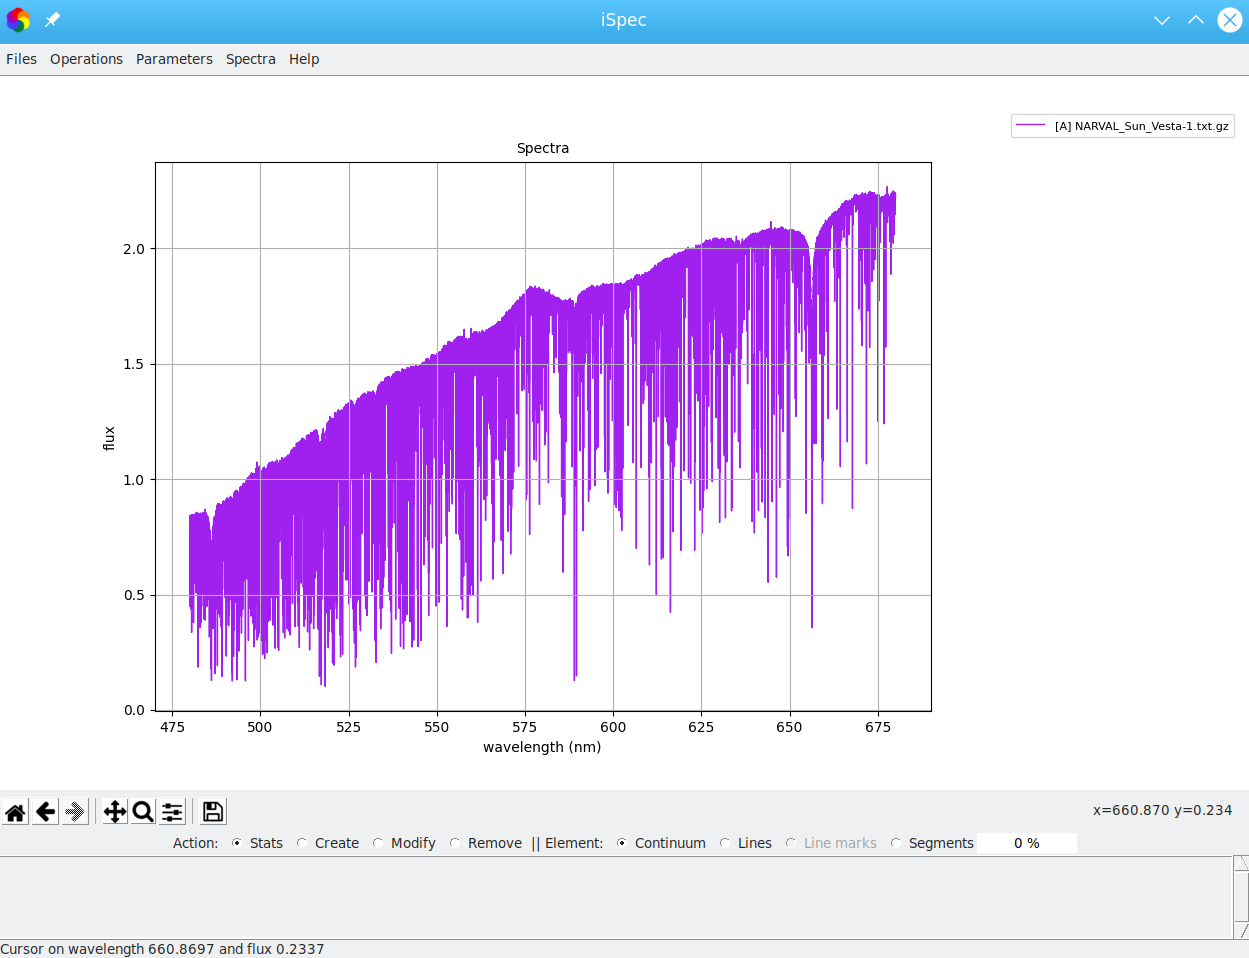

[This page](https://www.blancocuaresma.com/s/iSpec/manual/usage) provides further information about the visual interface.

## 3. Spectra file formats


### 3.1 FITS files

iSpec can read FITS files which meet any of these requirements:

- 1-D FITS file with CDELT/CRVAL values in the header and fluxes in the primary extension.

- FITS files containing a table in the primary extension where columns are wavelength, fluxes and, optionally, errors.

In both cases, Angstrom is assumed as unit and transformed to nanometers internally, unless the CUNIT value is set on the header indicating otherwise.

### 3.2 Plain text files

In this case, the file must contain the following columns:

- waveobs: wavelength in nanometers.
- flux.
- err: error in the flux. In case the error is unknown, it can be set to zero.

To sum up, iSpec can read a file as simple as this one:

    waveobs       flux          err
    370.000000000 1.26095742505 1.53596736433
    370.001897436 1.22468868618 1.55692475754
    370.003794872 1.18323884263 1.47304952231
    370.005692308 1.16766911881 1.49393329036

Or this one:

    waveobs       flux          err
    370.000000000 1.26095742505 0.0
    370.001897436 1.22468868618 0.0
    370.003794872 1.18323884263 0.0
    370.005692308 1.16766911881 0.0

## 4. Python functions

Although the visual interface gives the possibility of performing some tasks, a Python script is required to take advantage of all the functionalities available in iSpec. In the iSpec directory, created after the installation, there is a file named 'example.py' which includes an extensive [list of examples](https://www.blancocuaresma.com/s/iSpec/manual/scripting/basics). Some of these functions are shown in the next sections.

### 4.1 Loading the required packages and setting the iSpec directory

In [42]:
import os
import sys
import logging
import numpy as np
import matplotlib.pyplot as plt

# iSpec directory
ispec_dir = '/usr/local/ispec/iSpec_v20201001'

# import functions included in the iSpec module
sys.path.insert(0, os.path.abspath(ispec_dir))
import ispec

# Change LOG level
LOG_LEVEL = "info"
logger = logging.getLogger() # root logger, common for all
logger.setLevel(logging.getLevelName(LOG_LEVEL.upper()))

### 4.2 Basic functions

In [43]:
# Read spectrum
def read_spectrum(spectrum):
    logging.info("Reading spectrum")
    star_spectrum = ispec.read_spectrum(spectrum)
    return star_spectrum

# Cut spectrum
def cut_spectrum_from_range(spectrum, wave_min, wave_max):
    logging.info("Cutting...")

    # - Keep points between two given wavelengths
    wfilter = ispec.create_wavelength_filter(spectrum, wave_base=wave_min, wave_top=wave_max)
    cutted_star_spectrum = spectrum[wfilter]
    
    return cutted_star_spectrum

# Telluric velocity shift determination from spectrum
def determine_telluric_velocity_shift_from_spectrum(spectrum):
    logging.info("Telluric velocity shift determination...")
    
    # - Telluric
    telluric_linelist_file = ispec_dir + "/input/linelists/CCF/Synth.Tellurics.500_1100nm/mask.lst"
    telluric_linelist = ispec.read_telluric_linelist(telluric_linelist_file, minimum_depth=0.0)
    
    models, ccf = ispec.cross_correlate_with_mask(spectrum, telluric_linelist, \
                            lower_velocity_limit=-100, upper_velocity_limit=100, \
                            velocity_step=0.5, mask_depth=0.01, \
                            fourier = False,
                            only_one_peak = True)

    vel_telluric = np.round(models[0].mu(), 2) # km/s
    vel_telluric_err = np.round(models[0].emu(), 2) # km/s
    
    return [vel_telluric, vel_telluric_err]

# Plot spectrum
def plot_spectrum(spectrum, xmin=-99, xmax=-99, ymin=-99, ymax=-99, color='#1f77b4',
                 grid = False, title = None, ylabel = 'Flux', xlabel = 'Wavelength (nm)'):
    
    # Create figure
    figure = plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    
    # Add grid, if desired
    if grid:
        ax1.grid(True, which="both")
    
    # Add title, if desired
    if title is not None:
        ax1.set_title(title, fontsize="10")
    
    # Add xlabel
    if xlabel is not None:
        ax1.set_xlabel(xlabel, fontsize="10")
    
    # Add ylabel
    if ylabel is not None:
        ax1.set_ylabel(ylabel, fontsize="10")
        
    # Set x axis limits
    if (xmin < 0):
        xmin = np.min(spectrum['waveobs'])
    
    if (xmax < 0):
        xmax = np.max(spectrum['waveobs'])
    
    plt.gca().set_xlim(left=xmin, right=xmax)
    
    # Set y axis limits
    if (ymin < 0):
        ymin = np.min(spectrum['flux'])
    
    if (ymax < 0):
        ymax = np.max(spectrum['flux'])
    
    plt.gca().set_ylim(bottom=ymin, top=ymax)
    
    ax1.plot(spectrum['waveobs'], spectrum['flux'], lw=1, color=color)        
    
    plt.show()


[2024-01-09 00:34:55,868] [INFO] [4249574285:read_spectrum:3]: Reading spectrum


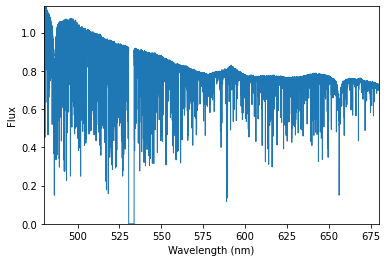

In [44]:
# Read Procyon spectrum     
pro_spec = read_spectrum(ispec_dir + "/input/spectra/examples/HARPS.GBOG_Procyon.txt.gz")

# Plot Procyon spectrum
plot_spectrum(pro_spec)

### 4.3  Radial velocity correction

In [45]:
# Derive the radial velocity of the star
def determine_radial_velocity_with_mask(spectrum):
    logging.info("Radial velocity determination with linelist mask...")
    
    # - Read atomic data
    #mask_file = ispec_dir + "/input/linelists/CCF/Narval.Sun.370_1048nm/mask.lst"
    #mask_file = ispec_dir + "/input/linelists/CCF/Atlas.Arcturus.372_926nm/mask.lst""
    #mask_file = ispec_dir + "/input/linelists/CCF/Atlas.Sun.372_926nm/mask.lst"
    #mask_file = ispec_dir + "/input/linelists/CCF/HARPS_SOPHIE.A0.350_1095nm/mask.lst"
    mask_file = ispec_dir + "/input/linelists/CCF/HARPS_SOPHIE.F0.360_698nm/mask.lst"
    #mask_file = ispec_dir + "/input/linelists/CCF/HARPS_SOPHIE.G2.375_679nm/mask.lst"
    #mask_file = ispec_dir + "/input/linelists/CCF/HARPS_SOPHIE.K0.378_679nm/mask.lst"
    #mask_file = ispec_dir + "/input/linelists/CCF/HARPS_SOPHIE.K5.378_680nm/mask.lst"
    #mask_file = ispec_dir + "/input/linelists/CCF/HARPS_SOPHIE.M5.400_687nm/mask.lst"
    #mask_file = ispec_dir + "/input/linelists/CCF/Synthetic.Sun.350_1100nm/mask.lst"
    #mask_file = ispec_dir + "/input/linelists/CCF/VALD.Sun.300_1100nm/mask.lst"
    ccf_mask = ispec.read_cross_correlation_mask(mask_file)

    models, ccf = ispec.cross_correlate_with_mask(spectrum, ccf_mask, \
                            lower_velocity_limit=-200, upper_velocity_limit=200, \
                            velocity_step=1.0, mask_depth=0.01, \
                            fourier=False)

    rv = np.round(models[0].mu(), 2) # km/s
    rv_err = np.round(models[0].emu(), 2) # km/s
    
    return [rv, rv_err]

# Radial velocity correction
def correct_radial_velocity(spectrum, rv):
    logging.info("Radial velocity correction...")
    corrected_spectrum = ispec.correct_velocity(spectrum, rv)
    return corrected_spectrum


In [46]:
# Determine Procyon radial velocity
pro_rv = determine_radial_velocity_with_mask(pro_spec)
print('Procyon RV = ' + str(pro_rv[0]) + ' +/- ' + str(pro_rv[1]) + ' km/s')

# Correct Procyon spectrum from radial velocity shift
pro_spec_cor = correct_radial_velocity(pro_spec, pro_rv[0])

[2024-01-09 00:34:56,691] [INFO] [38289316:determine_radial_velocity_with_mask:3]: Radial velocity determination with linelist mask...
[2024-01-09 00:34:56,767] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2024-01-09 00:34:56,790] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 10.22%
[2024-01-09 00:34:56,824] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 20.45%
[2024-01-09 00:34:56,847] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 30.67%
[2024-01-09 00:34:56,876] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 40.90%
[2024-01-09 00:34:56,920] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 60.10%
[2024-01-09 00:34:56,943] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 70.32%
[2024-01-09 00:34:56,965] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 80.55%
[2024-01-09 00:34:56,983] [INFO] [lines:__

Procyon RV = -3.14 +/- 0.05 km/s


### 4.4 Continuum normalization

In [47]:
# Normalize star spectrum
def normalize_spectrum_using_continuum_regions(spectrum, resolution):
    """
    Consider only continuum regions for the fit, strategy 'median+max'
    """
    
    #--- Continuum fit -------------------------------------------------------------
    model = "Splines" # "Polynomy"
    degree = 2
    nknots = None # Automatic: 1 spline every 5 nm
    from_resolution = resolution

    # Strategy: Filter first median values and secondly MAXIMUMs in order to find the continuum
    order='median+max'
    median_wave_range=0.05
    max_wave_range=1.0

    continuum_regions = ispec.read_continuum_regions(ispec_dir + "/input/regions/fe_lines_continuum.txt")
    star_continuum_model = ispec.fit_continuum(spectrum, from_resolution=from_resolution, \
                            continuum_regions=continuum_regions, nknots=nknots, degree=degree, \
                            median_wave_range=median_wave_range, \
                            max_wave_range=max_wave_range, \
                            model=model, order=order, \
                            automatic_strong_line_detection=True, \
                            strong_line_probability=0.5, \
                            use_errors_for_fitting=True)

    #--- Continuum normalization ---------------------------------------------------
    logging.info("Continuum normalization...")
    normalized_star_spectrum = ispec.normalize_spectrum(spectrum, star_continuum_model,
                                                        consider_continuum_errors=False)
    
    return normalized_star_spectrum


[2024-01-09 00:34:57,082] [INFO] [4249574285:cut_spectrum_from_range:9]: Cutting...
[2024-01-09 00:34:57,115] [INFO] [continuum:__fit_continuum:637]: Resampling spectrum to wave_step: 0.00574 nm (R = 115000)
[2024-01-09 00:34:57,186] [INFO] [continuum:__median_filter:307]: Median filter with step: 9
[2024-01-09 00:34:57,189] [INFO] [continuum:__max_filter:298]: Max filter with step: 175
[2024-01-09 00:34:57,541] [INFO] [3460555326:normalize_spectrum_using_continuum_regions:29]: Continuum normalization...


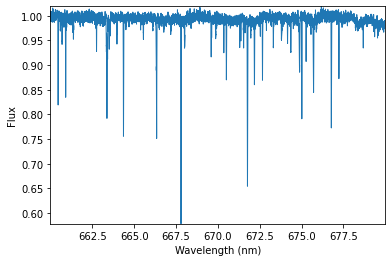

In [48]:
# Cut Procyon (RV corrected) spectrum
pro_spec_cut = cut_spectrum_from_range(pro_spec_cor, 660, 680)

# Normalize Procyon (RV corrected) spectrum
pro_spec_nor = normalize_spectrum_using_continuum_regions(pro_spec_cut, 115000)

# Plot RV corrected and continuum normalized Procyon spectrum
plot_spectrum(pro_spec_nor)

### 4.5 Deriving stellar parameters

One of the most useful functionalities included in iSpec is the determination of stellar parameters and chemical abundances comparing the observed spectrum with synthetic spectra. This tool includes different radiative transfer codes for this purpose, among them: [SPECTRUM](http://www.appstate.edu/~grayro/spectrum/spectrum.html), [Turbospectrum](https://www.lupm.in2p3.fr/users/plez/), [SME](https://www.stsci.edu/~valenti/sme.html) and [MOOG](http://www.as.utexas.edu/~chris/moog.html). The user can generate the synthetic spectra on the fly or use a pre-computed grid of spectra.

In [49]:
# Determine stellar parameters using synthetic spectra generated on the fly with the SPECTRUM radiative transfer code
def determine_astrophysical_parameters_using_synth_spectra(star_spectrum, resolution, params_list, code="spectrum"):
    
    #--- Resolution degradation ----------------------------------------------------
    # NOTE: The line selection was built based on a solar spectrum with R ~ 47,000 and GES/VALD atomic linelist.
    from_resolution = resolution
    to_resolution = 47000
    star_spectrum = ispec.convolve_spectrum(star_spectrum, to_resolution, from_resolution)
    
    #--- Normalize -------------------------------------------------------------
    # Use a fixed value because the spectrum is already normalized
    star_continuum_model = ispec.fit_continuum(star_spectrum, fixed_value=1.0, model="Fixed value")
    normalized_star_spectrum = ispec.normalize_spectrum(star_spectrum, star_continuum_model, consider_continuum_errors=False)
    
    #--- Model spectra ----------------------------------------------------------
    # Parameters
    initial_teff = 5750.0
    initial_logg = 4.5
    initial_MH = 0.00
    initial_alpha = ispec.determine_abundance_enchancements(initial_MH)
    initial_vmic = ispec.estimate_vmic(initial_teff, initial_logg, initial_MH)
    initial_vmac = ispec.estimate_vmac(initial_teff, initial_logg, initial_MH)
    initial_vsini = 1.60 # Sun
    initial_limb_darkening_coeff = 0.6
    initial_R = to_resolution
    initial_vrad = 0
    max_iterations = 10

    # Selected model amtosphere, linelist and solar abundances
    #model = ispec_dir + "/input/atmospheres/MARCS/"
    model = ispec_dir + "/input/atmospheres/MARCS.GES/"
    #model = ispec_dir + "/input/atmospheres/MARCS.APOGEE/"
    #model = ispec_dir + "/input/atmospheres/ATLAS9.APOGEE/"
    #model = ispec_dir + "/input/atmospheres/ATLAS9.Castelli/"
    #model = ispec_dir + "/input/atmospheres/ATLAS9.Kurucz/"
    #model = ispec_dir + "/input/atmospheres/ATLAS9.Kirby/"

    #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.300_1100nm/atomic_lines.tsv"
    #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.1100_2400nm/atomic_lines.tsv"
    atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_hfs_iso.420_920nm/atomic_lines.tsv"
    #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_nohfs_noiso.420_920nm/atomic_lines.tsv"

    if "ATLAS" in model:
        solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.1998/stdatom.dat"
    else:
        # MARCS
        solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.2007/stdatom.dat"
    #solar_abundances_file = ispec_dir + "/input/abundances/Asplund.2005/stdatom.dat"
    #solar_abundances_file = ispec_dir + "/input/abundances/Asplund.2009/stdatom.dat"
    #solar_abundances_file = ispec_dir + "/input/abundances/Anders.1989/stdatom.dat"

    isotope_file = ispec_dir + "/input/isotopes/SPECTRUM.lst"

    # Load chemical information and linelist
    atomic_linelist = ispec.read_atomic_linelist(atomic_linelist_file, wave_base=np.min(star_spectrum['waveobs']), wave_top=np.max(star_spectrum['waveobs']))
    atomic_linelist = atomic_linelist[atomic_linelist['theoretical_depth'] >= 0.01] # Select lines that have some minimal contribution in the sun

    isotopes = ispec.read_isotope_data(isotope_file)

    # Load model atmospheres
    modeled_layers_pack = ispec.load_modeled_layers_pack(model)

    # Load SPECTRUM abundances
    solar_abundances = ispec.read_solar_abundances(solar_abundances_file)

    # Free parameters
    #free_params = ["teff", "logg", "MH", "vmic", "vmac", "vsini", "R", "vrad", "limb_darkening_coeff"]
    free_params = params_list

    # Free individual element abundance
    free_abundances = None
    linelist_free_loggf = None

    # Line regions
    line_regions = ispec.read_line_regions(ispec_dir + 
                                           "/input/regions/47000_GES/{}_synth_good_for_params_all.txt".format(code))
    #line_regions = ispec.read_line_regions(ispec_dir + "/input/regions/47000_GES/{}_synth_good_for_params_all_extended.txt".format(code))
    #line_regions = ispec.read_line_regions(ispec_dir + "/input/regions/47000_VALD/{}_synth_good_for_params_all.txt".format(code))
    #line_regions = ispec.read_line_regions(ispec_dir + "/input/regions/47000_VALD/{}_synth_good_for_params_all_extended.txt".format(code))
    
    line_regions = ispec.adjust_linemasks(normalized_star_spectrum, line_regions, max_margin=0.5)
    
    # Read segments if we have them or...
    #segments = ispec.read_segment_regions(ispec_dir + "/input/regions/fe_lines_segments.txt")
    # ... or we can create the segments on the fly:
    segments = ispec.create_segments_around_lines(line_regions, margin=0.25)

    obs_spec, modeled_synth_spectrum, params, errors, abundances_found, loggf_found, status, stats_linemasks = \
            ispec.model_spectrum(normalized_star_spectrum, star_continuum_model, \
            modeled_layers_pack, atomic_linelist, isotopes, solar_abundances, free_abundances, linelist_free_loggf, initial_teff, \
            initial_logg, initial_MH, initial_alpha, initial_vmic, initial_vmac, initial_vsini, \
            initial_limb_darkening_coeff, initial_R, initial_vrad, free_params, segments=segments, \
            linemasks=line_regions, \
            enhance_abundances=False, \
            use_errors = True, \
            vmic_from_empirical_relation = True, \
            vmac_from_empirical_relation = True, \
            max_iterations=max_iterations, \
            tmp_dir = None, \
            code=code)
    
    ##--- Save results -------------------------------------------------------------
    logging.info("Saving synthetic spectrum...")
    synth_filename = "example_modeled_synth_%s.fits" % (code)
    ispec.write_spectrum(modeled_synth_spectrum, synth_filename)
    
    ##--- Return stellar parameters ------------------------------------------------
    return [params, errors]

In [50]:
# Determine Procyon effective temperature
free_params = ["teff"]
pro_params = determine_astrophysical_parameters_using_synth_spectra(pro_spec_nor, 115000, free_params,
                                                                    code="spectrum")

[2024-01-09 00:34:58,418] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Generating: 5750 4.50 0.00 0.00 1.05 4.10 1.60 0.60 47000 loggf [] abund [] vrad []


[2024-01-09 00:35:04,568] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Iter       1    CHI-SQUARE =  829.5539302  DOF =  941
   teff = 5750  
   logg = 4.5  
   MH = 0  
   alpha = 0  
   Vmic = 1.05  
   Vmac = 4.1  
   Vsini = 1.6  
   limb_darkening_coeff = 0.6  
   R = 47000  
Generating: 5850 4.50 0.00 0.00 1.08 4.53 1.60 0.60 47000 loggf [] abund [] vrad []


[2024-01-09 00:35:06,715] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Generating: 6377 4.50 0.00 0.00 1.31 7.96 1.60 0.60 47000 loggf [] abund [] vrad []


[2024-01-09 00:35:09,168] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Iter       2    CHI-SQUARE =  52.7883334  DOF =  941
   teff = 6376.712254  
   logg = 4.5  
   MH = 0  
   alpha = 0  
   Vmic = 1.31  
   Vmac = 7.96  
   Vsini = 1.6  
   limb_darkening_coeff = 0.6  
   R = 47000  
Generating: 6477 4.50 0.00 0.00 1.37 8.84 1.60 0.60 47000 loggf [] abund [] vrad []


[2024-01-09 00:35:11,796] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Generating: 6426 4.50 0.00 0.00 1.34 8.39 1.60 0.60 47000 loggf [] abund [] vrad []


[2024-01-09 00:35:14,354] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Iter       3    CHI-SQUARE =  49.60495838  DOF =  941
   teff = 6426.213822  
   logg = 4.5  
   MH = 0  
   alpha = 0  
   Vmic = 1.34  
   Vmac = 8.39  
   Vsini = 1.6  
   limb_darkening_coeff = 0.6  
   R = 47000  
Generating: 6526 4.50 0.00 0.00 1.39 9.30 1.60 0.60 47000 loggf [] abund [] vrad []


[2024-01-09 00:35:16,750] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Generating: 6424 4.50 0.00 0.00 1.34 8.36 1.60 0.60 47000 loggf [] abund [] vrad []


[2024-01-09 00:35:19,045] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Iter       4    CHI-SQUARE =  49.52866927  DOF =  941
   teff = 6423.675803  
   logg = 4.5  
   MH = 0  
   alpha = 0  
   Vmic = 1.34  
   Vmac = 8.36  
   Vsini = 1.6  
   limb_darkening_coeff = 0.6  
   R = 47000  
Generating: 6524 4.50 0.00 0.00 1.39 9.27 1.60 0.60 47000 loggf [] abund [] vrad []


[2024-01-09 00:35:21,291] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Cache: 6424 4.50 0.00 0.00 1.34 8.37 1.60 0.60 47000 loggf [] abund [] vrad []


[2024-01-09 00:35:21,504] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Cache: 6424 4.50 0.00 0.00 1.34 8.36 1.60 0.60 47000 loggf [] abund [] vrad []


[2024-01-09 00:35:21,725] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Cache: 6424 4.50 0.00 0.00 1.34 8.36 1.60 0.60 47000 loggf [] abund [] vrad []


[2024-01-09 00:35:21,966] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!
[2024-01-09 00:35:22,040] [INFO] [1933381466:determine_astrophysical_parameters_using_synth_spectra:103]: Saving synthetic spectrum...




          wave_peak	wave_base	wave_top	  wchisq	 rwchisq	   chisq	  rchisq	     rms
Line        480.06	  480.03	  480.08	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        480.10	  480.08	  480.14	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        481.20	  481.16	  481.21	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        489.64	  489.62	  489.68	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        491.80	  491.76	  491.82	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        491.90	  491.88	  491.96	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        491.99	  491.96	  492.00	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        492.05	  492.00	  492.09	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        492.43	  492.42	  492.45	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        492.48	  492.45	  492.51	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        492.56	  492.54	  492.

In [51]:
print('Procyon Teff = ' + str(np.round(pro_params[0]['teff'], 0)) + ' +/- ' + 
      str(np.round(pro_params[1]['teff'], 0)) + ' K')

Procyon Teff = 6424.0 +/- 28.0 K


### 4.6 Deriving equivalent widths and abundances

In [52]:
# Derive equivalent widths of a specific element
def fit_lines_determine_ew_and_crossmatch_with_atomic_data(star_spectrum, resolution, element, vel_telluric, 
                                                           use_ares=False):
    
    #--- Resolution degradation ----------------------------------------------------
    # NOTE: The line selection was built based on a solar spectrum with R ~ 47,000 and GES/VALD atomic linelist.
    from_resolution = resolution
    to_resolution = 47000
    star_spectrum = ispec.convolve_spectrum(star_spectrum, to_resolution, from_resolution)
    
    #--- Normalize -------------------------------------------------------------
    # Use a fixed value because the spectrum is already normalized
    star_continuum_model = ispec.fit_continuum(star_spectrum, fixed_value=1.0, model="Fixed value")
    normalized_star_spectrum = ispec.normalize_spectrum(star_spectrum, star_continuum_model, consider_continuum_errors=False)
    
    #--- Fit lines -----------------------------------------------------------------
    logging.info("Fitting lines...")
    #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.300_1100nm/atomic_lines.tsv"
    #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.1100_2400nm/atomic_lines.tsv"
    atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_hfs_iso.420_920nm/atomic_lines.tsv"
    #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_nohfs_noiso.420_920nm/atomic_lines.tsv"


    # Read
    atomic_linelist = ispec.read_atomic_linelist(atomic_linelist_file, wave_base=np.min(star_spectrum['waveobs']), wave_top=np.max(star_spectrum['waveobs']))
    atomic_linelist = atomic_linelist[atomic_linelist['theoretical_depth'] >= 0.01] # Select lines that have some minimal contribution in the sun
    
    telluric_linelist_file = ispec_dir + "/input/linelists/CCF/Synth.Tellurics.500_1100nm/mask.lst"
    telluric_linelist = ispec.read_telluric_linelist(telluric_linelist_file, minimum_depth=0.01)
    
    # Iron
    if element == 'Fe':
        line_regions = ispec.read_line_regions(ispec_dir + "/input/regions/fe_lines.txt")
    
    # Other elements
    else:
        line_regions = ispec.read_line_regions(ispec_dir + 
                                               "/input/regions/47000_GES/moog_synth_good_for_params_all.txt")
        #line_regions = ispec.read_line_regions(ispec_dir + "/input/regions/47000_GES/width_synth_good_for_params_all.txt")
        #line_regions = ispec.read_line_regions(ispec_dir + "/input/regions/47000_VALD/moog_synth_good_for_params_all.txt")
        #line_regions = ispec.read_line_regions(ispec_dir + "/input/regions/47000_VALD/width_synth_good_for_params_all.txt")

        
    line_regions = ispec.adjust_linemasks(normalized_star_spectrum, line_regions, max_margin=0.5)

    linemasks = ispec.fit_lines(line_regions, normalized_star_spectrum, star_continuum_model, \
                                atomic_linelist = atomic_linelist, \
                                #max_atomic_wave_diff = 0.005, \
                                max_atomic_wave_diff = 0.02, \
                                telluric_linelist = telluric_linelist, \
                                smoothed_spectrum = None, \
                                check_derivatives = False, \
                                vel_telluric = vel_telluric, discard_gaussian=False, \
                                discard_voigt=True, \
                                free_mu=True, crossmatch_with_mu=False, closest_match=False)
    
    # Discard lines that are not cross matched with the same original element stored in the note
    linemasks = linemasks[linemasks['element'] == line_regions['note']]

    # Exclude lines that have not been successfully cross matched with the atomic data
    # because we cannot calculate the chemical abundance (it will crash the corresponding routines)
    rejected_by_atomic_line_not_found = (linemasks['wave_nm'] == 0)
    linemasks = linemasks[~rejected_by_atomic_line_not_found]

    # Exclude lines with EW equal to zero
    rejected_by_zero_ew = (linemasks['ew'] == 0)
    linemasks = linemasks[~rejected_by_zero_ew]

    # Exclude lines that may be affected by tellurics
    rejected_by_telluric_line = (linemasks['telluric_wave_peak'] != 0)
    linemasks = linemasks[~rejected_by_telluric_line]

    if use_ares:
        # Replace the measured equivalent widths by the ones computed by ARES
        old_linemasks = linemasks.copy()
        ### Different rejection parameters (check ARES papers):
        ##   - http://adsabs.harvard.edu/abs/2007A%26A...469..783S
        ##   - http://adsabs.harvard.edu/abs/2015A%26A...577A..67S
        #linemasks = ispec.update_ew_with_ares(normalized_star_spectrum, linemasks, rejt="0.995", tmp_dir=None, verbose=0)
        #linemasks = ispec.update_ew_with_ares(normalized_star_spectrum, linemasks, rejt="3;5764,5766,6047,6052,6068,6076", tmp_dir=None, verbose=0)
        snr = 50
        linemasks = ispec.update_ew_with_ares(normalized_star_spectrum, linemasks, rejt="%s" % (snr), tmp_dir=None, verbose=0)

    ew = linemasks['ew']
    ew_err = linemasks['ew_err']

    # Save linemasks (line masks + atomic cross-matched information + fit information)
    ispec.write_line_regions(linemasks, "example_fitted_atomic_linemask.txt", extended=True)
    
    # Return equivalent widths derived
    return [ew, ew_err]

In [53]:
# Derive telluric velocity shift for Procyon spectrum
pro_vel_tel = determine_telluric_velocity_shift_from_spectrum(pro_spec)

# Derive iron equivalent widths for Procyon
pro_fe_ew = fit_lines_determine_ew_and_crossmatch_with_atomic_data(pro_spec_nor, 115000, 'Fe', pro_vel_tel[0],
                                                                   use_ares=False)

[2024-01-09 00:35:22,095] [INFO] [4249574285:determine_telluric_velocity_shift_from_spectrum:19]: Telluric velocity shift determination...
[2024-01-09 00:35:22,970] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2024-01-09 00:35:23,014] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 10.22%
[2024-01-09 00:35:23,060] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 20.45%
[2024-01-09 00:35:23,114] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 30.67%
[2024-01-09 00:35:23,170] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 40.90%
[2024-01-09 00:35:23,273] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 60.10%
[2024-01-09 00:35:23,332] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 70.32%
[2024-01-09 00:35:23,390] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 80.55%
[2024-01-09 00:35:23,449] [INFO] [line

- Atomic line's range from 660.1124 to 679.9001 nm
- Linemask range from 480.28746 to 679.32582 nm


In [54]:
# Derive chemical abundance of a specific element
def determine_abundances_using_synth_spectra(star_spectrum, resolution, element, teff, code="spectrum"):

    #--- Resolution degradation ----------------------------------------------------
    # NOTE: The line selection was built based on a solar spectrum with R ~ 47,000 and GES/VALD atomic linelist.
    from_resolution = resolution
    to_resolution = 47000
    star_spectrum = ispec.convolve_spectrum(star_spectrum, to_resolution, from_resolution)

    #--- Normalize -------------------------------------------------------------
    # Use a fixed value because the spectrum is already normalized
    star_continuum_model = ispec.fit_continuum(star_spectrum, fixed_value=1.0, model="Fixed value")
    normalized_star_spectrum = ispec.normalize_spectrum(star_spectrum, star_continuum_model, consider_continuum_errors=False)
    
    #--- Model spectra ----------------------------------------------------------
    # Parameters
    initial_teff = teff
    initial_logg = 4.5
    initial_MH = 0.00
    initial_alpha = ispec.determine_abundance_enchancements(initial_MH)
    initial_vmic = ispec.estimate_vmic(initial_teff, initial_logg, initial_MH)
    initial_vmac = ispec.estimate_vmac(initial_teff, initial_logg, initial_MH)
    initial_vsini = 1.60 # Sun
    initial_limb_darkening_coeff = 0.6
    initial_R = to_resolution
    initial_vrad = 0
    max_iterations = 10

    # Selected model amtosphere, linelist and solar abundances
    #model = ispec_dir + "/input/atmospheres/MARCS/"
    model = ispec_dir + "/input/atmospheres/MARCS.GES/"
    #model = ispec_dir + "/input/atmospheres/MARCS.APOGEE/"
    #model = ispec_dir + "/input/atmospheres/ATLAS9.APOGEE/"
    #model = ispec_dir + "/input/atmospheres/ATLAS9.Castelli/"
    #model = ispec_dir + "/input/atmospheres/ATLAS9.Kurucz/"
    #model = ispec_dir + "/input/atmospheres/ATLAS9.Kirby/"

    #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.300_1100nm/atomic_lines.tsv"
    #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.1100_2400nm/atomic_lines.tsv"
    atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_hfs_iso.420_920nm/atomic_lines.tsv"
    #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_nohfs_noiso.420_920nm/atomic_lines.tsv"

    if "ATLAS" in model:
        solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.1998/stdatom.dat"
    else:
        # MARCS
        solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.2007/stdatom.dat"
    #solar_abundances_file = ispec_dir + "/input/abundances/Asplund.2005/stdatom.dat"
    #solar_abundances_file = ispec_dir + "/input/abundances/Asplund.2009/stdatom.dat"
    #solar_abundances_file = ispec_dir + "/input/abundances/Anders.1989/stdatom.dat"

    isotope_file = ispec_dir + "/input/isotopes/SPECTRUM.lst"

    # Load chemical information and linelist
    atomic_linelist = ispec.read_atomic_linelist(atomic_linelist_file, wave_base=np.min(star_spectrum['waveobs']), wave_top=np.max(star_spectrum['waveobs']))
    atomic_linelist = atomic_linelist[atomic_linelist['theoretical_depth'] >= 0.01] # Select lines that have some minimal contribution in the sun

    isotopes = ispec.read_isotope_data(isotope_file)
    
    # Load model atmospheres
    modeled_layers_pack = ispec.load_modeled_layers_pack(model)

    # Load SPECTRUM abundances
    solar_abundances = ispec.read_solar_abundances(solar_abundances_file)

    # Free parameters
    free_params = []

    # Free individual element abundance (WARNING: it should be coherent with the selected line regions!)
    chemical_elements_file = ispec_dir + "/input/abundances/chemical_elements_symbols.dat"
    chemical_elements = ispec.read_chemical_elements(chemical_elements_file)

    element_name = element
    free_abundances = ispec.create_free_abundances_structure([element_name], chemical_elements, solar_abundances)
    free_abundances['Abund'] += initial_MH # Scale to metallicity

    linelist_free_loggf = None

    # Line regions
    line_regions = ispec.read_line_regions(ispec_dir + 
                                           "/input/regions/47000_GES/{}_synth_good_for_params_all.txt".format(code))
    #line_regions = ispec.read_line_regions(ispec_dir + "/input/regions/47000_GES/{}_synth_good_for_params_all_extended.txt".format(code))
    #line_regions = ispec.read_line_regions(ispec_dir + "/input/regions/47000_VALD/{}_synth_good_for_params_all.txt".format(code))
    #line_regions = ispec.read_line_regions(ispec_dir + "/input/regions/47000_VALD/{}_synth_good_for_params_all_extended.txt".format(code))
    
    # Select only the lines to get abundances from
    line_regions = line_regions[np.logical_or(line_regions['note'] == element_name+' 1', 
                                              line_regions['note'] == element_name+' 2')]
    
    line_regions = ispec.adjust_linemasks(normalized_star_spectrum, line_regions, max_margin=0.5)

    # Read segments if we have them or...
    #segments = ispec.read_segment_regions(ispec_dir + "/input/regions/fe_lines_segments.txt")
    # ... or we can create the segments on the fly:
    segments = ispec.create_segments_around_lines(line_regions, margin=0.25)

    obs_spec, modeled_synth_spectrum, params, errors, abundances_found, loggf_found, status, stats_linemasks = \
            ispec.model_spectrum(normalized_star_spectrum, star_continuum_model, \
            modeled_layers_pack, atomic_linelist, isotopes, solar_abundances, free_abundances, linelist_free_loggf, initial_teff, \
            initial_logg, initial_MH, initial_alpha, initial_vmic, initial_vmac, initial_vsini, \
            initial_limb_darkening_coeff, initial_R, initial_vrad, free_params, segments=segments, \
            linemasks=line_regions, \
            enhance_abundances=False, \
            use_errors = True, \
            vmic_from_empirical_relation = True, \
            vmac_from_empirical_relation = True, \
            max_iterations=max_iterations, \
            tmp_dir = None, \
            code=code)

    ##--- Save results -------------------------------------------------------------
    logging.info("Saving synthetic spectrum...")
    synth_filename = "example_modeled_synth_abundances_%s.fits" % (code)
    ispec.write_spectrum(modeled_synth_spectrum, synth_filename)
    
    # Return abundances derived
    return abundances_found

In [55]:
# Derive iron abundance for Procyon
pro_Fe_abund = determine_abundances_using_synth_spectra(pro_spec_nor, 115000, 'Fe', pro_params[0]['teff'],
                                                    code="spectrum")

[2024-01-09 00:35:30,840] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Generating: 6424 4.50 0.00 0.00 1.34 8.36 1.60 0.60 47000 loggf [] abund [-4.59] vrad []


[2024-01-09 00:35:36,735] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Iter       1    CHI-SQUARE =  46.7720498  DOF =  693
   teff = 6423.675803  
   logg = 4.5  
   MH = 0  
   alpha = 0  
   Vmic = 1.34  
   Vmac = 8.36  
   Vsini = 1.6  
   limb_darkening_coeff = 0.6  
   R = 47000  
   26 = -4.59  
Generating: 6424 4.50 0.00 0.00 1.34 8.36 1.60 0.60 47000 loggf [] abund [-4.54] vrad []


[2024-01-09 00:35:38,545] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Generating: 6424 4.50 0.00 0.00 1.34 8.36 1.60 0.60 47000 loggf [] abund [-4.65] vrad []


[2024-01-09 00:35:40,421] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Iter       2    CHI-SQUARE =  41.87944599  DOF =  693
   teff = 6423.675803  
   logg = 4.5  
   MH = 0  
   alpha = 0  
   Vmic = 1.34  
   Vmac = 8.36  
   Vsini = 1.6  
   limb_darkening_coeff = 0.6  
   R = 47000  
   26 = -4.646623297  
Generating: 6424 4.50 0.00 0.00 1.34 8.36 1.60 0.60 47000 loggf [] abund [-4.60] vrad []


[2024-01-09 00:35:42,247] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Cache: 6424 4.50 0.00 0.00 1.34 8.36 1.60 0.60 47000 loggf [] abund [-4.65] vrad []


[2024-01-09 00:35:42,463] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Cache: 6424 4.50 0.00 0.00 1.34 8.36 1.60 0.60 47000 loggf [] abund [-4.65] vrad []


[2024-01-09 00:35:42,690] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!


Cache: 6424 4.50 0.00 0.00 1.34 8.36 1.60 0.60 47000 loggf [] abund [-4.65] vrad []


[2024-01-09 00:35:42,897] [INFO] [spectrum:__convolve_spectrum:789]: Spectra convolved!
[2024-01-09 00:35:42,952] [INFO] [741088202:determine_abundances_using_synth_spectra:112]: Saving synthetic spectrum...




          wave_peak	wave_base	wave_top	  wchisq	 rwchisq	   chisq	  rchisq	     rms
Line        480.06	  480.03	  480.08	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        489.64	  489.62	  489.68	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        491.80	  491.76	  491.82	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        491.90	  491.88	  491.96	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        492.05	  492.00	  492.09	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        492.43	  492.42	  492.45	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        492.48	  492.45	  492.51	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        493.88	  493.85	  493.90	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        494.56	  494.56	  494.58	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        494.64	  494.62	  494.68	-9999.00	-9999.0000	-9999.00	-9999.0000	-9999.0000
Line        495.76	  495.74	  495.

In [56]:
print('Procyon [Fe/H] = ' + str(np.round(pro_Fe_abund['[X/H]'][0], 2)) + ' +/- ' + 
      str(np.round(pro_Fe_abund['e[X/H]'][0], 2)))

Procyon [Fe/H] = -0.06 +/- 0.03
